<a href="https://colab.research.google.com/github/aka2910/GNR650-Ass1/blob/main/GNR650_Ass_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
# Set a fixed random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [9]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])



In [16]:
model = torchvision.models.resnet18(pretrained=False, num_classes=10)
# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [17]:
# Training Loop
batch_size = 32
num_samples_per_class = 20  # Number of samples per class

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Stratified Sampling to Create Subset
labels = np.array(trainset.targets)
stratified_splitter = StratifiedShuffleSplit(n_splits=1, train_size=num_samples_per_class * 10, test_size=len(trainset) - num_samples_per_class * 10)
train_indices, _ = next(stratified_splitter.split(labels, labels))
limited_trainset = torch.utils.data.Subset(trainset, train_indices)

limited_loader = DataLoader(limited_trainset, batch_size=batch_size, shuffle=True)
print('Limited Training Set Size:', len(limited_trainset))
print('Original Test Set Size:', len(trainset) - len(limited_trainset))



Files already downloaded and verified
Limited Training Set Size: 200
Original Test Set Size: 49800


In [18]:
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in limited_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Epoch [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'.format(epoch + 1, num_epochs, running_loss / len(limited_loader), 100 * correct / total))



Epoch [1/20], Loss: 2.5758, Accuracy: 12.50%
Epoch [2/20], Loss: 2.3416, Accuracy: 24.00%
Epoch [3/20], Loss: 2.4223, Accuracy: 33.00%
Epoch [4/20], Loss: 1.8769, Accuracy: 47.50%
Epoch [5/20], Loss: 1.5663, Accuracy: 51.50%
Epoch [6/20], Loss: 1.1970, Accuracy: 70.00%
Epoch [7/20], Loss: 0.9128, Accuracy: 70.00%
Epoch [8/20], Loss: 0.8277, Accuracy: 72.50%
Epoch [9/20], Loss: 1.0582, Accuracy: 75.50%
Epoch [10/20], Loss: 0.7708, Accuracy: 77.00%
Epoch [11/20], Loss: 0.7029, Accuracy: 81.50%
Epoch [12/20], Loss: 1.0134, Accuracy: 83.50%
Epoch [13/20], Loss: 1.2902, Accuracy: 72.50%
Epoch [14/20], Loss: 1.3179, Accuracy: 74.00%
Epoch [15/20], Loss: 0.8638, Accuracy: 78.00%
Epoch [16/20], Loss: 0.9995, Accuracy: 74.00%
Epoch [17/20], Loss: 0.7383, Accuracy: 78.00%
Epoch [18/20], Loss: 0.7064, Accuracy: 82.00%
Epoch [19/20], Loss: 0.9462, Accuracy: 84.00%
Epoch [20/20], Loss: 1.0012, Accuracy: 81.50%


In [19]:
# Test Performance (using the entire test set)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in testloader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Test Accuracy: {:.2f}%'.format(100 * correct / total))

Files already downloaded and verified
Test Accuracy: 22.72%


In [21]:
import matplotlib.pyplot as plt

def visualize_kernels(model, layer_name, num_kernels=8):
    layer = model
    for name in layer_name.split('.'):
        layer = layer._modules[name]

    kernels = layer.weight.data.cpu().numpy()
    num_kernels = min(num_kernels, kernels.shape[0])

    fig, axs = plt.subplots(1, num_kernels, figsize=(15, 2))
    for i in range(num_kernels):
        kernel = kernels[i]
        axs[i].imshow(kernel[0])
        axs[i].axis('off')
    plt.show()

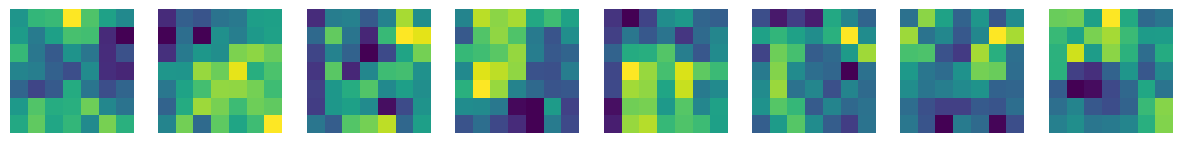

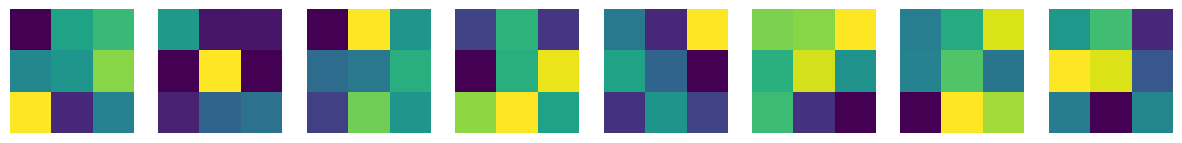

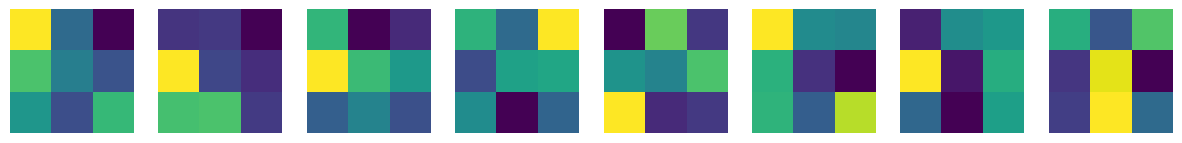

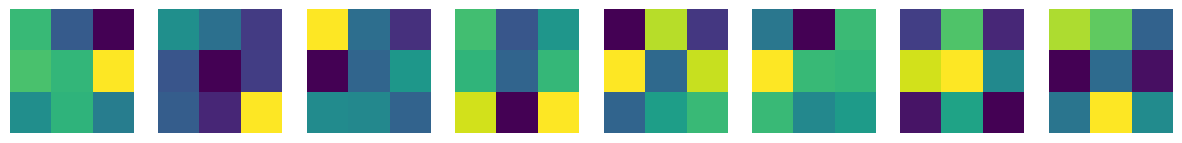

In [22]:
# Visualize Kernels at Different Layers
visualize_kernels(model, 'conv1')  # Visualize kernels of the first convolutional layer
visualize_kernels(model, 'layer1.0.conv1')  # Visualize kernels of the first convolutional layer in the first residual block
visualize_kernels(model, 'layer2.0.conv1')  # Visualize kernels of the first convolutional layer in the second residual block
visualize_kernels(model,"layer4.1.conv2")


In [23]:
def check_weight_magnitudes(model):
    for name, param in model.named_parameters():
        if 'weight' in name:
            print(f'{name}: {param.data.norm()}')

check_weight_magnitudes(model)

conv1.weight: 5.867685794830322
bn1.weight: 8.142169952392578
layer1.0.conv1.weight: 11.824161529541016
layer1.0.bn1.weight: 8.003251075744629
layer1.0.conv2.weight: 11.84288501739502
layer1.0.bn2.weight: 7.934043884277344
layer1.1.conv1.weight: 11.767675399780273
layer1.1.bn1.weight: 8.002466201782227
layer1.1.conv2.weight: 11.678718566894531
layer1.1.bn2.weight: 7.9351091384887695
layer2.0.conv1.weight: 12.052839279174805
layer2.0.bn1.weight: 11.315618515014648
layer2.0.conv2.weight: 16.62474822998047
layer2.0.bn2.weight: 11.253043174743652
layer2.0.downsample.0.weight: 11.52934741973877
layer2.0.downsample.1.weight: 11.441048622131348
layer2.1.conv1.weight: 16.5877628326416
layer2.1.bn1.weight: 11.315194129943848
layer2.1.conv2.weight: 16.47606086730957
layer2.1.bn2.weight: 11.251924514770508
layer3.0.conv1.weight: 16.807769775390625
layer3.0.bn1.weight: 16.00084686279297
layer3.0.conv2.weight: 23.106534957885742
layer3.0.bn2.weight: 15.977401733398438
layer3.0.downsample.0.weight: 

In [33]:
model = torchvision.models.resnet18(pretrained=False, num_classes=10)
model.to(device)  # Move the model to the GPU
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)


In [34]:
# Training Loop
batch_size = 32
num_samples_per_class = 4000  # Number of samples per class

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Stratified Sampling to Create Subset
labels = np.array(trainset.targets)
stratified_splitter = StratifiedShuffleSplit(n_splits=1, train_size=num_samples_per_class * 10, test_size=len(trainset) - num_samples_per_class * 10)
train_indices, _ = next(stratified_splitter.split(labels, labels))
limited_trainset = torch.utils.data.Subset(trainset, train_indices)

limited_loader = DataLoader(limited_trainset, batch_size=batch_size, shuffle=True)
print('Limited Training Set Size:', len(limited_trainset))
print('Original Test Set Size:', len(trainset) - len(limited_trainset))



Files already downloaded and verified
Limited Training Set Size: 40000
Original Test Set Size: 10000


In [35]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in limited_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to GPU
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Epoch [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'.format(epoch + 1, num_epochs, running_loss / len(limited_loader), 100 * correct / total))


Epoch [1/10], Loss: 1.7300, Accuracy: 41.41%
Epoch [2/10], Loss: 1.2704, Accuracy: 56.96%
Epoch [3/10], Loss: 1.0293, Accuracy: 64.97%
Epoch [4/10], Loss: 0.8531, Accuracy: 70.54%
Epoch [5/10], Loss: 0.7151, Accuracy: 75.48%
Epoch [6/10], Loss: 0.6188, Accuracy: 78.63%
Epoch [7/10], Loss: 0.5187, Accuracy: 82.05%
Epoch [8/10], Loss: 0.4289, Accuracy: 85.30%
Epoch [9/10], Loss: 0.3600, Accuracy: 87.39%
Epoch [10/10], Loss: 0.2974, Accuracy: 89.69%


In [38]:
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)  # Move data to GPU
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Test Accuracy: {:.2f}%'.format(100 * correct / total))

Files already downloaded and verified
Test Accuracy: 73.20%


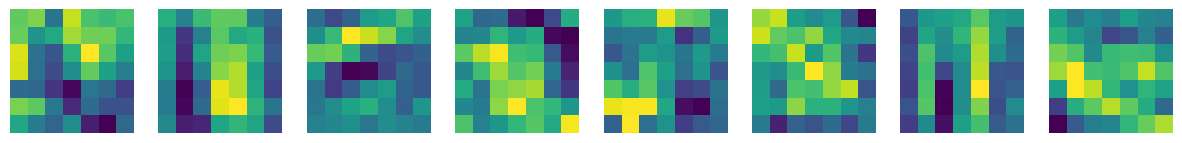

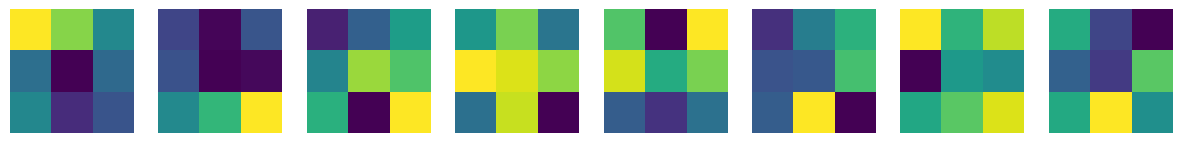

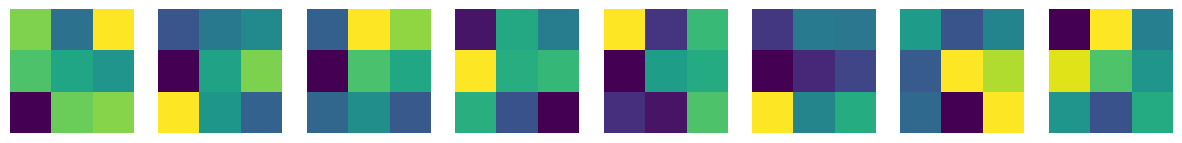

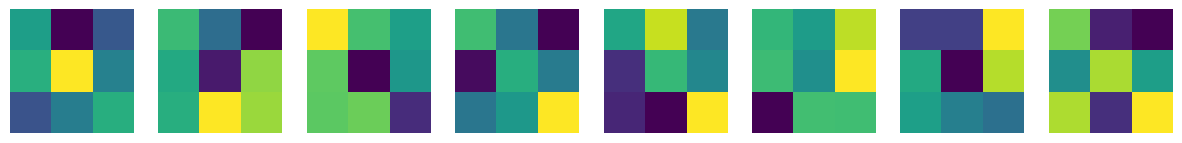

In [36]:
# Visualize Kernels at Different Layers
visualize_kernels(model, 'conv1')  # Visualize kernels of the first convolutional layer
visualize_kernels(model, 'layer1.0.conv1')  # Visualize kernels of the first convolutional layer in the first residual block
visualize_kernels(model, 'layer2.0.conv1')  # Visualize kernels of the first convolutional layer in the second residual block
visualize_kernels(model,"layer4.1.conv2")


In [39]:
def check_weight_magnitudes(model):
    for name, param in model.named_parameters():
        if 'weight' in name:
            print(f'{name}: {param.data.norm()}')

check_weight_magnitudes(model)

conv1.weight: 13.058143615722656
bn1.weight: 9.622817993164062
layer1.0.conv1.weight: 14.585318565368652
layer1.0.bn1.weight: 8.045860290527344
layer1.0.conv2.weight: 14.668742179870605
layer1.0.bn2.weight: 7.300532817840576
layer1.1.conv1.weight: 14.245604515075684
layer1.1.bn1.weight: 7.987305641174316
layer1.1.conv2.weight: 14.372980117797852
layer1.1.bn2.weight: 7.086160182952881
layer2.0.conv1.weight: 16.572391510009766
layer2.0.bn1.weight: 11.224126815795898
layer2.0.conv2.weight: 21.518978118896484
layer2.0.bn2.weight: 11.421260833740234
layer2.0.downsample.0.weight: 13.254408836364746
layer2.0.downsample.1.weight: 11.81130599975586
layer2.1.conv1.weight: 20.769935607910156
layer2.1.bn1.weight: 11.216437339782715
layer2.1.conv2.weight: 19.865676879882812
layer2.1.bn2.weight: 10.557374000549316
layer3.0.conv1.weight: 21.4148006439209
layer3.0.bn1.weight: 15.975729942321777
layer3.0.conv2.weight: 25.205913543701172
layer3.0.bn2.weight: 15.900592803955078
layer3.0.downsample.0.weig